# Backtesting the Model

Once we have fetched the data and pretrained the model, we can now turn to using the model.

---

This notebook demonstrates how to:

- **Load Model**: I have already fine-tuned models from the training output. Download them from Huggingface, or run the `prepare.py` and `torchrun` the `train.py` scripts to generate new weights.
- **Generate Signals**: Run the test dataset (Trump's Truth Social posts from H1 2025) through the fine-tuned model to get predictions `(Bullish, Bearish, Neutral)`.
- **Run VectorBT Backtest**: Use `vectorbt` to run a portfolio simulation.
    - Use the signals to generate trade entries and exits.
    - Compare the strategy's performance against the VOO price data (buy and hold benchmark).

In [87]:
import os
import io
import time
import requests
import torch

import xml.etree.ElementTree as ET
import polars as pl
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import vectorbt as vbt

from bs4 import BeautifulSoup
from datetime import date
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

trump_start = dt.datetime(2017, 1, 17)
trump_end = dt.datetime(2021, 1, 9)

csv_filename = 'truths_data_2025_h1.csv'

def fetch_truths(start_date, end_date):
    url = f"https://trumpstruth.org/feed?start_date={start_date}&end_date={end_date}"
    print(f"Fetching data for {start_date} to {end_date}...")

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"  -> Error fetching data for this period: {e}")
        return pl.DataFrame()
    except ET.ParseError:
        print("  -> Failed to parse XML, skipping this period.")
        return pl.DataFrame()


    rss_feed = io.StringIO(response.text)
    tree = ET.parse(rss_feed)
    root = tree.getroot()

    posts = []
    for item in root.findall('./channel/item'):
        pub_date = item.find('pubDate').text
        description_html = item.find('description').text
        soup = BeautifulSoup(description_html, 'html.parser')
        text_content = soup.get_text().strip()
        posts.append({'date': pub_date, 'text': text_content})

    return pl.DataFrame(posts)

def fetch_h1():
    weekly_date_ranges = pl.date_range(start=date(2025, 1, 20), end=date(2025, 6, 30), interval='1w', eager=True)
    
    all_posts_dfs = []
    
    for start_of_week in weekly_date_ranges.to_pandas():
        end_of_week = start_of_week + pd.Timedelta(days=6)
        start_str = start_of_week.strftime('%Y-%m-%d')
        end_str = end_of_week.strftime('%Y-%m-%d')
    
        weekly_df = fetch_truths(start_str, end_str)
    
        all_posts_dfs.append(weekly_df)
    
        time.sleep(0.1)
    
    if all_posts_dfs:
        final_df = pl.concat(all_posts_dfs).with_columns(
            pl.col('date').str.to_datetime("%a, %d %b %Y %H:%M:%S %z")
        )
        final_df.write_csv(csv_filename, separator=",")
    
        print(f"\n✅ Success! Scraped {len(final_df)} posts.")
        print(f"Data saved to '{csv_filename}'.")
    else:
        print("\nNo data was fetched. The final CSV was not created.")

In [88]:
from pathlib import Path

file_path = Path(csv_filename)

if not file_path.is_file():
    fetch_h1()

schema_overrides = {
    "date": pl.Datetime,
    "text": pl.Utf8
}

# remove posts that contain no text or just http links
dataset = (
    pl.read_csv(file_path, schema_overrides=schema_overrides)
    .drop_nulls()
    .filter(
        (pl.col("text").str.strip_chars().str.len_chars() > 0) &
        (~pl.col("text").str.contains(r"^https?://[\S]+$"))
    )
)

print(f"Loaded and filtered {len(dataset)} posts.")
dataset.head()

Loaded and filtered 1329 posts.


date,text
datetime[μs],str
2025-01-26 21:19:22,"""RT @marklevinshowTonight on Li…"
2025-01-26 20:58:10,"""The great Sean Hannity in the …"
2025-01-26 19:05:24,"""Tonight on Life, Liberty & Lev…"
2025-01-26 18:28:31,"""I was just informed that two r…"
2025-01-26 01:20:39,"""Be sure to watch Mark Levin's …"


In [89]:
from transformers import pipeline, AutoTokenizer
import pandas as pd

# use ./ for local model if you trained, or use the HF downloader
model_path = "./bert-trump-tweet-voo" # Or "yen-av/bert-trump-tweet-voo"

tokenizer = AutoTokenizer.from_pretrained(model_path)

# truncate because Truth Social character limits > Twitter
classifier = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=tokenizer,
    truncation=True,
    max_length=512
)

test_data_df = dataset.to_pandas()

predictions = classifier(test_data_df['text'].tolist())

test_data_df['predicted_label'] = [p['label'] for p in predictions]
test_data_df['prediction_score'] = [p['score'] for p in predictions]

display(test_data_df.head())

Device set to use cuda:0


,date,text,predicted_label,prediction_score
0,2025-01-26 21:19:22,"RT @marklevinshowTonight on Life, Liberty & Le...",BEARISH,0.387169
1,2025-01-26 20:58:10,The great Sean Hannity in the Oval Office prio...,NEUTRAL,0.391954
2,2025-01-26 19:05:24,"Tonight on Life, Liberty & Levin, 8PM Eastern ...",BEARISH,0.421105
3,2025-01-26 18:28:31,I was just informed that two repatriation flig...,NEUTRAL,0.380059
4,2025-01-26 01:20:39,Be sure to watch Mark Levin's Show on Fox toni...,BEARISH,0.451203


/tmp/ipykernel_11430/10135582.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Backtest Results for H1 2025
Start                         2025-01-21 00:00:00
End                           2025-07-07 00:00:00
Period                          115 days 00:00:00
Start Value                             1000000.0
End Value                          1143054.719378
Total Return [%]                        14.305472
Benchmark Return [%]                     3.588362
Max Gross Exposure [%]                      100.0
Total Fees Paid                      31065.492263
Max Drawdown [%]                         2.609814
Max Drawdown Duration            34 days 00:00:00
Total Trades                                 15.0
Total Closed Trades                          14.0
Total Open Trades                             1.0
Open Trade PnL                       -1143.054719
Win Rate [%]                            64.285714
Best Trade [%]                           10.02328
Worst Trade [%]                         -2.260315
Avg Winning Trade [%]                    2.283071
Avg Losing Trade [%] 

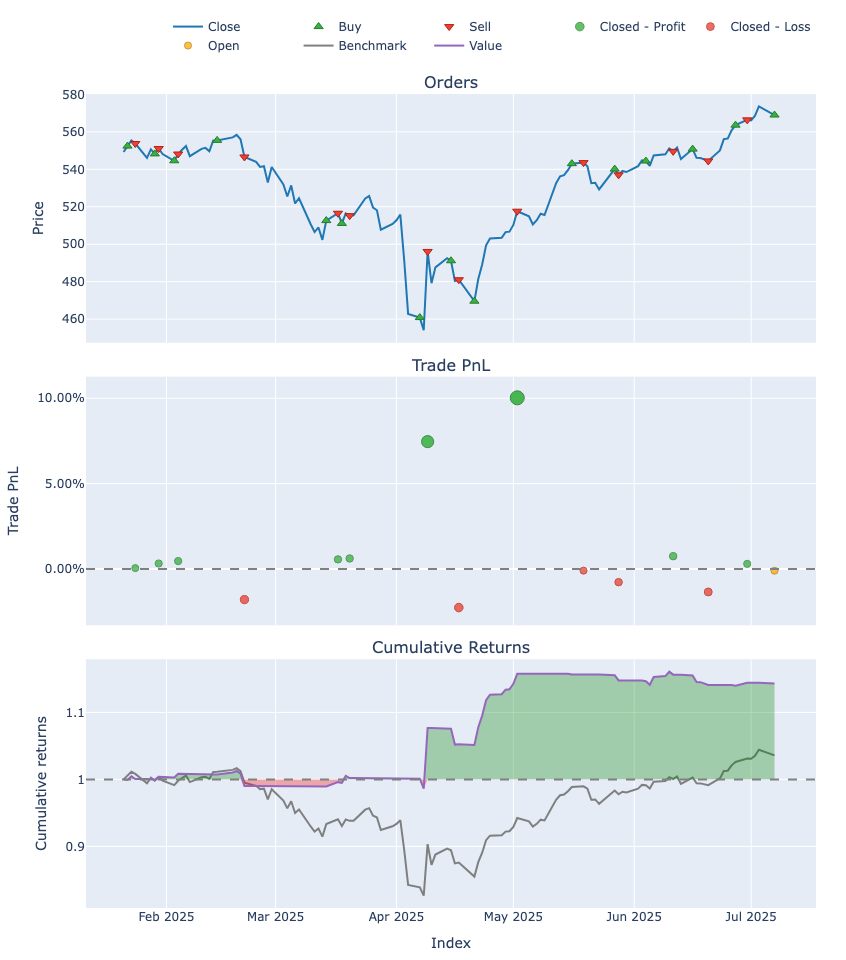

In [90]:
test_data_df['date'] = pd.to_datetime(test_data_df['date'])
test_data_df = test_data_df.set_index('date').sort_index()

start_date = test_data_df.index.min().strftime('%Y-%m-%d')
end_date = (test_data_df.index.max() + dt.timedelta(days=2)).strftime('%Y-%m-%d') 

# just use the close price for now
voo_price = yf.download('VOO', start=start_date, end=end_date)['Close']

signal_map = {
    'BULLISH': 1,  # Enter
    'BEARISH': -1, # Exit
    'NEUTRAL': 0   # Hold
}
test_data_df['signal'] = test_data_df['predicted_label'].map(signal_map)

# forward-fill signals to handle non-trading days
signals = test_data_df['signal'].reindex(voo_price.index, method='ffill').fillna(0)

entries = signals == 1
exits = signals == -1

portfolio = vbt.Portfolio.from_signals(
    close=voo_price, 
    entries=entries, 
    exits=exits,
    freq='D',
    init_cash=1000000,
    fees=0.001 # 0.1% fee per trade
)

print("Backtest Results for H1 2025")
print("="*30)
print(portfolio.stats())

print("\n\nPerformance vs. Buy and Hold (VOO)")
print("="*30)
portfolio[0].plot().show()

In [91]:
# Let's see what the model was actually predicting
print("Prediction distribution:")
print(test_data_df['predicted_label'].value_counts())

print("\nBreakdown by percentage:")
print(test_data_df['predicted_label'].value_counts(normalize=True) * 100)

Prediction distribution:
predicted_label
NEUTRAL    510
BEARISH    492
BULLISH    327
Name: count, dtype: int64

Breakdown by percentage:
predicted_label
NEUTRAL    38.374718
BEARISH    37.020316
BULLISH    24.604966
Name: proportion, dtype: float64


In [101]:
closed_trades = portfolio[0].trades.records

winning_trades = closed_trades[closed_trades['pnl'] > 0]

print(f"Found {len(winning_trades)} winning trades. Here are the posts that triggered them:\n")

for i, trade in winning_trades.iterrows():
    entry_idx_pos = int(trade['entry_idx'])
    entry_timestamp = voo_price.index[entry_idx_pos]

    exit_idx_pos = int(trade['exit_idx'])
    exit_timestamp = voo_price.index[exit_idx_pos]
    
    entry_triggers = test_data_df[test_data_df.index <= entry_timestamp]
    exit_triggers = test_data_df[test_data_df.index <= exit_timestamp]

    if not entry_triggers.empty:
        trigger_tweet = entry_triggers.iloc[-1]
        
        print(f"📈 Trade Profit: ${trade['pnl']:.2f}\n")
        print(f"Trade Entry Date: {entry_timestamp.strftime('%Y-%m-%d')}")
        print(f"Signal Date:      {trigger_tweet.name.strftime('%Y-%m-%d')}")
        print(f"Signal:           {trigger_tweet.predicted_label} {trigger_tweet.prediction_score}")
        print(f"Trigger Text:     \"{trigger_tweet['text']}\"\n")

    if not exit_triggers.empty: 
        trigger_tweet = exit_triggers.iloc[-1]
    
        print(f"Exit Date:        {exit_timestamp.strftime('%Y-%m-%d')}")
        print(f"Signal Date:      {trigger_tweet.name.strftime('%Y-%m-%d')}")
        print(f"Signal:           {trigger_tweet.predicted_label} {trigger_tweet.prediction_score}")
        print(f"Trigger Text:     \"{trigger_tweet['text']}\"\n\n")


Found 9 winning trades. Here are the posts that triggered them:

📈 Trade Profit: $507.70

Trade Entry Date: 2025-01-22
Signal Date:      2025-01-21
Signal:           BULLISH 0.3629707992076874
Trigger Text:     "I just called the mother of Ross William Ulbright to let her know that in honor of her and the Libertarian Movement, which supported me so strongly, it was my pleasure to have just signed a full and unconditional pardon of her son, Ross. The scum that worked to convict him were some of the same lunatics who were involved in the modern day weaponization of government against me. He was given two life sentences, plus 40 years. Ridiculous!"

Exit Date:        2025-01-24
Signal Date:      2025-01-23
Signal:           BEARISH 0.37550342082977295
Trigger Text:     "A special thank you to great New Jersey Congressman Jeff Van Drew for his fight against a large scale Windmill DISASTER off the coast of Southern New Jersey. It needed MASSIVE GOVERNMENT SUBSIDY that was impossible to just